In [2]:
import os
import os.path as op

import matplotlib.pyplot as plt

import hnn_core

from hnn_core import MPIBackend

from hnn_core.dipole import _rmse
from hnn_core.params import _short_name

from hnn_core import human_ET_model, simulate_dipole

pathfig = '/Users/katharinaduecker/Documents/projects_brown/hnn-tuning/gamma/figures/'
os.makedirs(pathfig, exist_ok=True)

In [8]:
# Test with default connectivity

net = human_ET_model()
net.set_cell_positions(inplane_distance=30.)

depths = list(list(range(-50,2200,150)))
electrode_pos = [(130, 130, dep) for dep in depths]
net.add_electrode_array('probe1', electrode_pos, method='lsa')

weights_ampa = {'L2_pyramidal': 0.0008, 'L5_pyramidal': 0.0075}
synaptic_delays = {'L2_pyramidal': 0.1, 'L5_pyramidal': 1.0}
rate_constant = {'L2_pyramidal': 140.0, 'L5_pyramidal': 40.0}
net.add_poisson_drive(
    'poisson', rate_constant=rate_constant, weights_ampa=weights_ampa,
    location='proximal', synaptic_delays=synaptic_delays,
    event_seed=1349)


# the new model has different membrane potentials in the different compartments -> requires a different baseline correction
# in addition to dipole and extracellular fields, we are recording membrane potentials (vsec), synaptic currents (isec) and calcium concentrations (ca) in all compartments
dpls = simulate_dipole(net, tstop=250., bsl_cor='calcium', record_vsec='all', record_isec='all', record_ca='all')


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Applying calcium model baseline correction


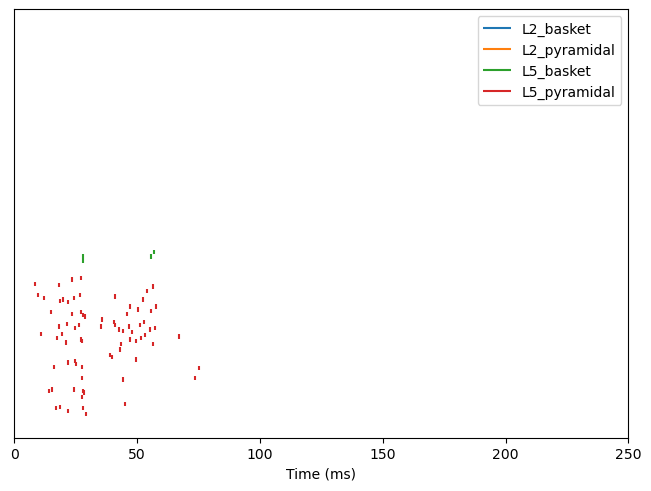

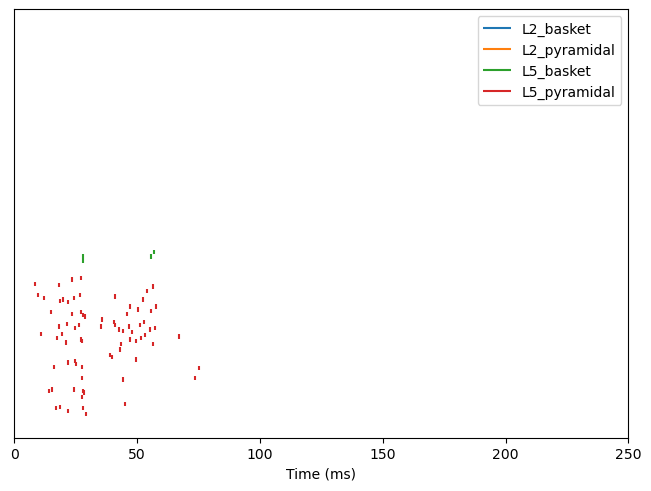

In [41]:
net.cell_response.plot_spikes_raster(show=False)


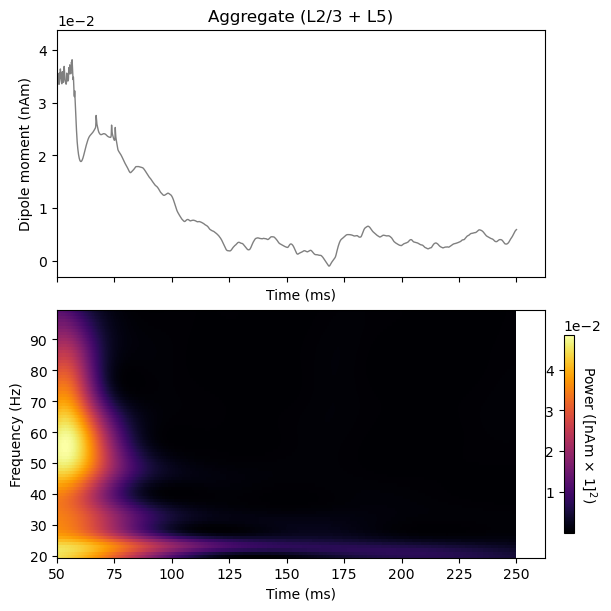

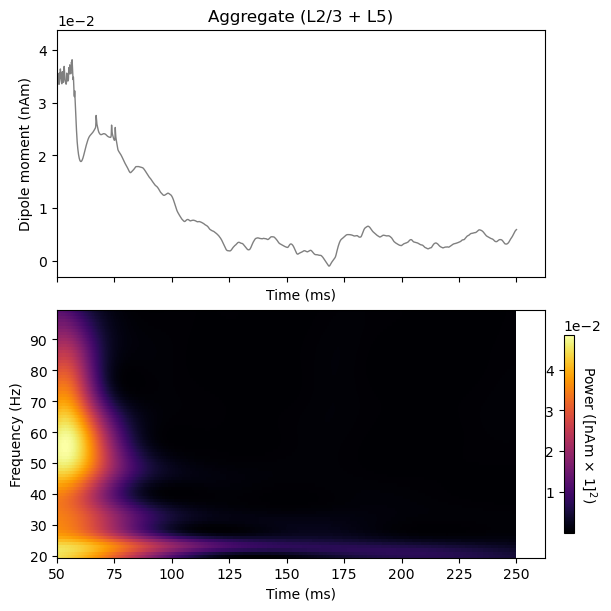

In [6]:

tmin = 50
trial_idx = 0  # pick first trial

# plot dipole time course and time-frequency representation in same figure
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)

dpls[trial_idx].plot(tmin=tmin, ax=axes[0], show=False)

# Create an fixed-step tiling of frequencies from 20 to 100 Hz in steps of 1 Hz
freqs = np.arange(20., 100., 1.)
dpls[trial_idx].plot_tfr_morlet(freqs, n_cycles=7, tmin=tmin, ax=axes[1])

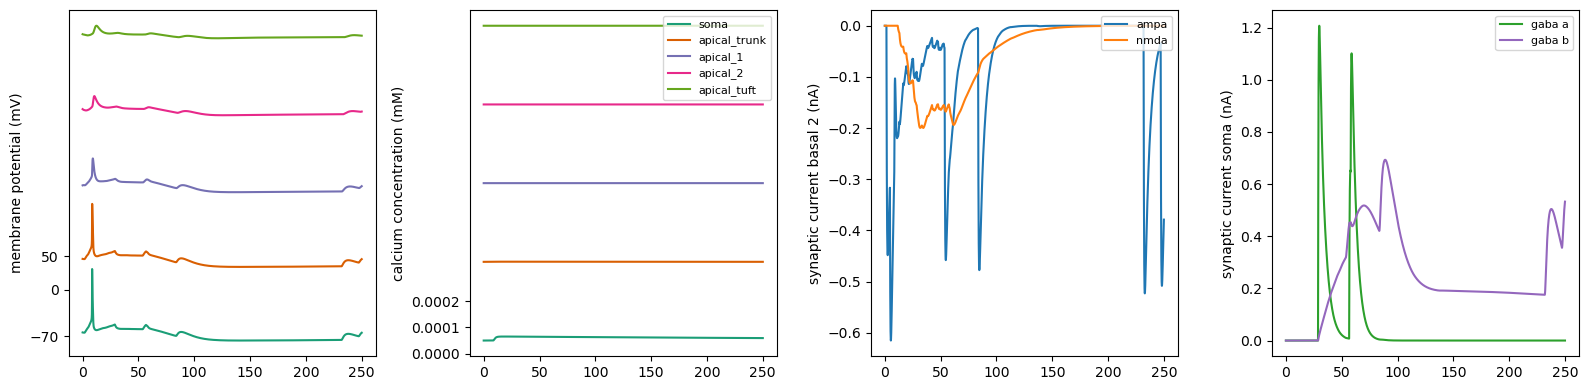

In [ ]:
# Plotting vsec, isec and ca for L5 Pyramidal

# find L5 neuron that spiked
spike_gid = np.array(net.cell_response.spike_gids[0])            # index 0 is the first trial
l5_spikes = spike_gid[(spike_gid >= 170) & (spike_gid < 270)]
timevec = net.cell_response.times

# snazzy colors I have used before
cols = np.array(([27, 158, 119], [217,95,2], [117,112,179], [231,41,138], [102,166,30]))/255

fig, axs = plt.subplots(1,4, figsize=(16,4), sharex=True)

sections = ['soma', 'apical_trunk', 'apical_1', 'apical_2', 'apical_tuft']
L = []
for section in sections:
    L.append(net.cell_types["L5_pyramidal"].sections[section].L)

prevL = 0
for i, section in enumerate(sections):

    v = np.array(net.cell_response.vsec[0][l5_spikes[0]][section])
    axs[0].plot(timevec, v + i*110, color=cols[i])
    ca = np.array(net.cell_response.ca[0][l5_spikes[0]][section])
    axs[1].plot(timevec, ca + i*0.0003, color=cols[i], label=section)
    prevL += L[i]

axs[0].set_ylabel('membrane potential (mV)')
axs[1].set_ylabel('calcium concentration (mM)')
axs[1].legend(loc='upper right', fontsize=8)
axs[0].set_yticks([-70, 0, 50])
axs[1].set_yticks([0, 0.0001, 0.0002])


axs[2].plot(net.cell_response.times,net.cell_response.isec[0][l5_spikes[0]]['basal_2']['basal_2_ampa'], label='ampa')
axs[2].plot(net.cell_response.times,net.cell_response.isec[0][l5_spikes[0]]['basal_2']['basal_2_nmda'], label='nmda')
axs[2].legend(loc='upper right', fontsize=8)

axs[2].set_ylabel('synaptic current basal 2 (nA)')

axs[3].plot(net.cell_response.times,net.cell_response.isec[0][l5_spikes[0]]['soma']['soma_gabaa'], label='gaba a', color='tab:green')
axs[3].plot(net.cell_response.times,net.cell_response.isec[0][l5_spikes[0]]['soma']['soma_gabab'], label='gaba b', color='tab:purple')
axs[3].legend(loc='upper right', fontsize=8)

axs[3].set_ylabel('synaptic current soma (nA)')
fig.tight_layout()